In [3]:
import pandas as pd
import weaviate
import weaviate.classes as wvc
import os
import requests
import json
from pprint import pprint
import tqdm
import matplotlib
from hnsw.keys import open_ai_key, weaviate_url, weaviate_key
from weaviate.classes.query import Move
import torch
from spacy import displacy

In [4]:
import openai
os.environ["OPENAI_APIKEY"] = open_ai_key
os.environ["WCD_URL"] = weaviate_url
os.environ["WCD_API_KEY"] = weaviate_key
openai.api_key = os.environ["OPENAI_APIKEY"]

In [5]:
# Load the transformer model and Spacy pipeline
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")

# Extract entities from text using spacey, the most important entities are products and organizations
def extract_entities(text):
    doc = nlp(text)
    products = [entity.text for entity in doc.ents if entity.label_ == "PRODUCT"]
    orgs = [entity.text for entity in doc.ents if entity.label_ == "ORG"]
    other = [entity.text for entity in doc.ents if entity.label_ not in ["PRODUCT", "ORG"]]
    return products, orgs, other

In [17]:
#Load in the job postings data, and have a look at the length of the descriptions
data = pd.read_csv("data/postings.csv")
data['desc_len'] = data['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)
data['desc_len'].describe()

count    123849.000000
mean       3766.251322
std        2146.618664
min           0.000000
25%        2176.000000
50%        3435.000000
75%        4986.000000
max       23201.000000
Name: desc_len, dtype: float64

In [68]:
# Use the extract_entities function to extract the entities from the descriptions using the spacy model
products, orgs, other = [], [], []
for i, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    try:
        p, o, ot = extract_entities(row['description'])
        products.append(p)
        orgs.append(o)
        other.append(ot)
    except Exception as e:
        print(e)
        products.append([])
        orgs.append([])
        other.append([])

data['products'] = products
data['orgs'] = orgs
data['other'] = other

 16%|█▋        | 20367/123849 [26:57<1:47:05, 16.11it/s]

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


 18%|█▊        | 22016/123849 [29:27<2:52:35,  9.83it/s]

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


 45%|████▍     | 55503/123849 [1:26:41<1:02:16, 18.29it/s]

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


 56%|█████▋    | 69769/123849 [1:45:35<47:46, 18.87it/s]  

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


 57%|█████▋    | 70633/123849 [1:46:33<55:03, 16.11it/s]  

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


 78%|███████▊  | 96730/123849 [2:22:33<24:48, 18.22it/s]  

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


 78%|███████▊  | 96995/123849 [2:22:53<24:29, 18.27it/s]

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


100%|██████████| 123849/123849 [2:59:47<00:00, 11.48it/s]  


In [87]:
# Convert the product froma list with repetions to a set
data.products = data.products.apply(lambda x: set(x))
#Save the data to a feather file with new NER
data.to_feather("data/postings.fth")

In [20]:
all_products = [product for products in data.products for product in products]

In [21]:
all_products = [product for products in data.products for product in products]
pd.Series(all_products).value_counts().head(500)

Excel                 14651
Word                   9352
Office                 5677
PowerPoint             5566
Python                 5338
                      ...  
TikTok                   39
OneSite                  39
RabbitMQ                 39
SkillBridge              39
Azure SQL Database       38
Name: count, Length: 500, dtype: int64

In [28]:
# Filter down list of jobs to a more manageable size using common ML / AI keywords
keywords = [
    "machine learning",
    "data science",
    "artificial intelligence",
    "deep learning",
    "neural networks",
    "NLP",
    "natural language processing",
    "computer vision",
    "data analysis",
    "predictive modeling",
    "big data",
    "Python",
    "TensorFlow",
    "PyTorch",
    "scikit-learn",
    "Keras",
    "data engineering",
    "algorithm development",
    "data mining",
    "reinforcement learning",
    " ML ",
    " AI "
]

pattern = '|'.join(keywords)
data['contains_keyword'] = data['description'].str.contains(pattern, case=False, na=False)
data['contains_keyword'].mean()

In [32]:
data.query('contains_keyword == True')

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,sponsored,work_type,currency,compensation_type,desc_len,skills_len,contains_keyword,products,orgs,other
5,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,...,0,INTERNSHIP,USD,BASE_SALARY,4188,0,True,[Office Suite],"[the Planning & Transportation Manager, DRA Ec...","[the upcoming summer semester, Raleigh, first,..."
6,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,...,0,CONTRACT,USD,BASE_SALARY,580,0,True,[],[],[]
78,2234533717,Ideando Inc,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a...",NaN,None,United States,69611476.0,21.0,NaN,...,0,FULL_TIME,None,None,3712,0,True,"[JavaScript/TypeScript, React, Node.js, Python...","[Remote, SkillFit, Ideando Inc., SkillFit, AWS...",[3+ years]
86,2735151240,LT Apparel Group,Intern- Business Analytics,Summer Internshipadidas & Carhartt kids Divisi...,NaN,None,Greensboro--Winston-Salem--High Point Area,103060.0,5.0,NaN,...,0,TEMPORARY,None,None,1777,0,True,"[Tableau, Power BI, Excel]","[Summer Internshipadidas, Carhartt, DivisionLT...","[Greensboro, NC, MBA, two]"
116,3245063922,Saxon AI,Data Architect,Request: Data ArchitectLocation: San Francisco...,NaN,None,"San Francisco, CA",224935.0,7.0,NaN,...,0,CONTRACT,None,None,381,0,True,"[EC2, S3, Lambda, Glue, athena, Firehose, SQL,...","[AWS, Kinesis, Kinesis]","[San Francisco, CA]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123797,3906263103,Rose International,Software Engineer,Date Posted: 04/19/2024Hiring Organization: Ro...,34.0,HOURLY,"Mossville, IL",12309.0,2.0,NaN,...,0,TEMPORARY,USD,BASE_SALARY,3286,0,True,"[Python, Python, Perl]","[Computer Information Systems, Office, HR Depa...","[462667Job, Mossville, IL, USA, months, 30.00M..."
123803,3906263308,UAMS - University of Arkansas for Medical Scie...,Research Assistant I- Pathology,Current University of Arkansas System employee...,NaN,None,"Little Rock, AR",11250.0,4.0,NaN,...,0,FULL_TIME,None,None,6605,0,True,"[Word, Excel]","[University of Arkansas System, Workday, Find ...","[two-year, Find Jobs for Students, 12:01 a.m. ..."
123830,3906265278,Associated Bank,React Native Developer,At Associated Bank we strive to create an incl...,NaN,None,"Milwaukee County, WI",8667.0,3.0,NaN,...,0,FULL_TIME,None,None,5765,0,True,"[React, Angular, Azure, C, #, VB .NET, Java, C...","[Associated Bank, Associated Bank, AWS, Associ...","[Arizona, Connecticut, Florida, Illinois, Iowa..."
123831,3906265301,RAND,Bachelor’s Level Research Assistant - Quantita...,Job Type\n\nTerm (Fixed Term)\n\nRAND is seeki...,NaN,None,"Pittsburgh, PA",165654.0,4.0,NaN,...,0,FULL_TIME,None,None,3937,0,True,"[Java, SQL, R]","[RAND, RAND, RAND]","[3 years, one, Mandarin, Arabic, Farsi, Dari, ..."


In [33]:
data['products_str'] = data['products'].apply(lambda x: ", ".join(x))

In [34]:
#Connect to Weaviate Cluster

client = weaviate.connect_to_wcs(
    cluster_url=os.getenv("WCD_URL"),
    auth_credentials=weaviate.auth.AuthApiKey(os.getenv("WCD_API_KEY")),
    headers={
        "X-OpenAI-Api-Key": os.environ["OPENAI_APIKEY"]  # Replace with your inference API key
    }
)

In [143]:
#Create a new collection called JobListings with the openAI text2vec model and gen model
#Just using autoschema here as the data is straightforward enough

listings = client.collections.create(
    name="JobListings",
    vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),  # If set to "none" you must always provide vectors yourself. Could be any other "text2vec-*" also.
    generative_config=wvc.config.Configure.Generative.openai()  # Ensure the `generative-openai` module is used for generative queries
    
)

In [ ]:
#Loading in the data into the collection by size of 100 pieces, as the data is resonbly large 
listings_objs = data.query('contains_keyword == True')[["job_id","company_name","title","description","skills_desc","products_str"]].fillna('').head(100_000).to_dict(orient="records")
pprint(listings_objs[0])

listings = client.collections.get("JobListings")

for i in range(0,10_000,100):
    print(i)
    try:
        listings.data.insert_many(listings_objs[i:i+100])
    except Exception as e:
        print(e)



In [41]:
#Quick test of some query functionailty

listings = client.collections.get("JobListings")

response = listings.query.near_text(
    query = ["Machine Learning"],
    # move_away=Move(force=1, concepts="Creative Industries"),
    move_to=Move(force=1, concepts="Finance"),
    return_metadata=[
            "creation_time",
            "last_update_time",
            "distance",
            "certainty",
            "score",
            "explain_score",
            "is_consistent",
        ],
    limit=1,

)
print(response.objects[0].uuid)
print(response.objects[0].properties['title'])
print(response.objects[0].properties['company_name'])
pprint(response.objects[0].properties['description'])
print(response.objects[0].properties['job_id'])
pprint(response.objects[0].properties['products_str'])

ed6e7fb0-3737-4382-84ee-f1bfa7d14763
Summer Data Scientist Internship
Lending Science DM
('Lending Science DM, Inc., the leader in Financial Services Marketing and '
 'Analytics seeks a Data Analyst in the financial services industry. This '
 'candidate must be a fast learner, dependable, energetic team player with a '
 'positive attitude. Ideal candidate will be in the latter part of their '
 'program pursuing degrees in Data Science, Industrial Engineering, '
 'Mathematics, Statistics or relevant degrees.This internship requires a 20 '
 'hour per week commitment with 2-3 days in an office environment and remote '
 'access during the remainder of the week. This will be a valuable experience '
 'for any student pursuing their career. This is a compensated internship. \n'
 'Responsibilities include and are not limited to:\n'
 'Interpreting data, analyzing results using statistical techniques and '
 'providing ongoing reports. Acquiring data from primary or secondary data '
 'sources and

In [42]:
item_details = {}
test = ''
for item in listings.iterator(include_vector=True):
    item_details[item.properties['job_id']] = {'uuid': item.uuid, 'embedding': item.vector['default']}

In [43]:
data_1k = data[data.job_id.isin(list(item_details.keys()))].copy()
data_1k.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'desc_len', 'skills_len', 'contains_keyword',
       'products', 'orgs', 'other', 'products_str'],
      dtype='object')

In [45]:
data_1k['vector'] = data_1k['job_id'].apply(lambda x: item_details[x]['embedding'])
data_1k['wv_uuid'] = data_1k['job_id'].apply(lambda x: str(item_details[x]['uuid']))

In [46]:
x = str(data_1k['wv_uuid'].iloc[0])

In [47]:
data_1k.to_feather("data/postings_10k.fth")


In [236]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval


matrix = np.array(data_1k['vector'].to_list())

In [237]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

In [263]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.array(data_1k['vector'].to_list())
n_clusters = 4

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
data_1k['Cluster'] = kmeans.labels_

c:\Users\Nick\.conda\envs\weaviate\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [258]:
data_1k['python'] = data_1k['prodcuts_str'].str.contains("Pytorch", case=False, na=False)
data_1k['python_int'] = data_1k['python'].astype(int)
data_1k['ml'] = data_1k['title'].str.contains("Machine Learning", case=False, na=False).astype(int)

26

Text(0.5, 1.0, 't-SNE of Job Postings')

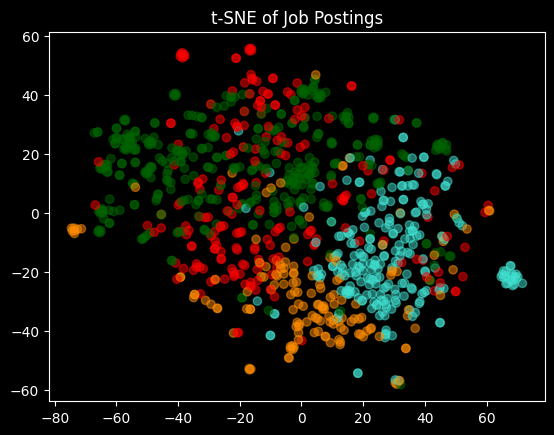

In [264]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x,y = vis_dims.T.tolist()

# x,y,z = vis_dims.T
# color_indices = df.Score.values - 1
color_indices = data_1k['Cluster'].values

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y,c=color_indices, cmap=colormap, alpha=0.5)

plt.title("t-SNE of Job Postings")

In [280]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot
# Assuming df is your DataFrame and it has columns 'tsne-2d-one', 'tsne-2d-two' and 'title'
fig = go.Figure(data=go.Scatter(
    x=x,
    y=y,
    # z=z,
    mode='markers',
    marker=dict(
        size=8,
        color=data_1k['Cluster'],  # set color to cluster values
        colorscale='Viridis',  # choose a colorscale
        opacity=0.8
    ),
    # marker=dict(size=8, opacity=0.5),
    text=data_1k['title']+' | '+data_1k['company_name'],  # this will set the hover text
    hoverinfo='text',
    
))

fig.update_layout(title='t-SNE plot',
                  xaxis=dict(title='Dimension 1'),
                  yaxis=dict(title='Dimension 2'),
                  hovermode='closest')

fig.show()

plot(fig)

'temp-plot.html'

In [277]:
from openai import OpenAI
import os

client = OpenAI(api_key=os.environ.get("OPENAI_APIKEY", "<your OpenAI API key if not set as env var>"))

# Reading a review which belong to each group.
rev_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        data_1k[data_1k.Cluster == i]
        .description
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
        {"role": "user", "content": f'What do the following job listings have in common?\n\nListings:\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = data_1k[data_1k.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.title.values[j], end=" | ")
        print(sample_cluster_rows.company_name.values[j], end="  |  ")
        print(sample_cluster_rows.products_str.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme: All of the job listings are related to recruitment, staffing, or human resources. They involve roles such as Growth Analyst, Human Resources Generalist, Supply Planner, Healthcare Analytic Consultant, Director of Finance, Materials Manager, Marketing Intern, Project Manager, Buyer Assistant, and National Recruiter. These listings all focus on aspects
Growth Specialist | Augment Jobs  |  Python, Mixpanel, SQL
Human Resources Generalist | California Health Care Foundation  |  Excel
Supply Chain Analyst - Consumer Goods | WhiteCap Search  |  Excel
Lead Analytic Consultant, Analytics | apree health  |  SAS, Gitlab, Analytics, Advanced Primary Care, Airflow, Mixpanel, a Go
Financial Director | GC Recruitment  |  
Senior Materials Manager | Whitaker Technical  |  Excel, Access
Marketing Intern (Canada) | Ardent Mills  |  
Project Manager | Just Whole Care  |  Agile
Assistant Buyer | JADE DRUG COMPANY, INC  |  Excel
Healthcare Recruiter | Planet Healthcare  |  
--------------

In [286]:
#Starting on companies and their products
companies = pd.read_csv("data/companies/companies.csv")
company_industries = pd.read_csv("data/companies/company_industries.csv")
comapny_specialties = pd.read_csv("data/companies/company_specialities.csv")
company_employee_counts  = pd.read_csv("data/companies/employee_counts.csv")

In [287]:
comapnies_data = companies.merge(company_industries, on="company_id", how="left")
comapnies_data = comapnies_data.merge(comapny_specialties, on="company_id", how="left")
comapnies_data = comapnies_data.merge(company_employee_counts, on="company_id", how="left")

In [288]:
comapnies_data.head()

,company_id,name,description,company_size,state,country,city,zip_code,address,url,industry,speciality,employee_count,follower_count,time_recorded
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,Cloud,314102,16253625,1712378162
1,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,Cloud,313142,16309464,1713392385
2,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,Cloud,313147,16309985,1713402495
3,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,Cloud,311223,16314846,1713501255
4,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,Mobile,314102,16253625,1712378162


In [ ]:
# Use the extract_entities function to extract the entities from the descriptions using the spacy model
products, orgs, other = [], [], []
for i, row in tqdm.tqdm(comapnies_data.iterrows(), total=len(data)):
    try:
        p, o, ot = extract_entities(row['description'])
        products.append(p)
        orgs.append(o)
        other.append(ot)
    except Exception as e:
        print(e)
        products.append([])
        orgs.append([])
        other.append([])

comapnies_data['products'] = products
comapnies_data['orgs'] = orgs
comapnies_data['other'] = other

comapnies_data.to_feather("data/companies_complete.fth")

comapnies_wv = client.collections.create(
    name="Comapnies",
    vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),  # If set to "none" you must always provide vectors yourself. Could be any other "text2vec-*" also.
    generative_config=wvc.config.Configure.Generative.openai()  # Ensure the `generative-openai` module is used for generative queries
    
)
companies_data = comapnies_data[comapnies_data['company_id'].isin(data['company_id'])]

comapnies_data['products_str'] = comapnies_data['products'].apply(lambda x: ", ".join(x))

companies_objs = data[["comapny_id","company_name","description","industry","speciality","employee_count","follower_count",'products_str']].fillna('').head(100_000).to_dict(orient="records")
pprint(listings_objs[0])

listings = client.collections.get("Comapnies")
# listings.data.insert_many(listings_objs)

listings.data.insert_many(companies_objs)